# Deep Belief Network, MNIST

In [1]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Set Configs

In [4]:
BATCH_SIZE = 64

## Load Datasets

In [5]:
mnist_datasets = torchvision.datasets.MNIST('./datasets/MNIST/', train=True, download=False,
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize((0.1307,), (0.3081,))]))

In [7]:
mnist_datasets.train_data = mnist_datasets.train_data.type(torch.FloatTensor)/255

## Visualize Datasets

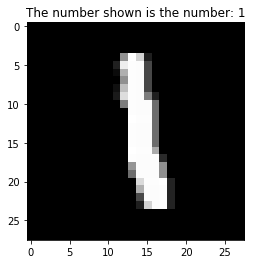

In [8]:
idx = np.random.randint(10)
image = mnist_datasets.train_data[idx]
plt.imshow(image, cmap='gray')
plt.title("The number shown is the number: {}".format(mnist_datasets.train_labels[idx]))
plt.show()

## Build The [Network](https://www.cs.toronto.edu/~hinton/absps/fastnc.pdf)

In [9]:
class RBMNet(nn.Module):
    
    def __init__(self, visible_units=256, hidden_units=64, k=2,
                       learning_rate=1e-5, learning_rate_decay=False,
                       xavier_init=False, increase_to_cd_k=False, use_gpu=False):
        
        super(RBMNet, self).__init__()
        self.desc = 'RBM Network'
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.k = k
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.xavier_init = xavier_init
        self.increase_to_cd_k = increase_to_cd_k
        self.use_gpu = use_gpu
        self.batch_size = 16
        
        if not self.xavier_init:
            self.W = torch.randn(self.visible_units, self.hidden_units) * 0.01
        else:
            self.xavier_value = torch.sqrt(torch.FloatTensor([1.0 / (self.visible_units + self.hidden_units)]))
            self.W = -self.xavier_value + torch.rand(self.visible_units, self.hidden_units) * (2 * self.xavier_value)
        self.h_bias = torch.zeros(self.hidden_units)
        self.v_bias = torch.zeros(self.visible_units)
        
    def bernoulli_sampling(self, prob):
        sample = torch.distributions.Bernoulli(prob).sample()
        return sample
    
    def visible_to_hidden(self, v):
        
        h_prob = torch.add(torch.matmul(v, self.W), self.h_bias)
        h_prob = torch.sigmoid(h_prob)
        sample_h_prob = self.bernoulli_sampling(h_prob)
        
        return h_prob, sample_h_prob
    
    def hidden_to_visible(self, h):
        
        v_prob = torch.add(torch.matmul(h, self.W.transpose(0, 1)), self.v_bias)
        v_prob = torch.sigmoid(v_prob)
        sample_v_prob = self.bernoulli_sampling(v_prob)
        
        return v_prob, sample_v_prob
    
    def reconstruction_error(self, data):
        return self.contrastive_divergence(data, False)
    
    def reconstruct(self, x, n_gibbs):
        v = x
        for k in range(n_gibbs):
            h_prob, h = self.visible_to_hidden(v)
            v_prob, v = self.hidden_to_visible(h_prob)
        
        return v_prob, v
    
    def contrastive_divergence(self, x, n_gibbs_sampling_steps=1, lr=0.001, train=True):
        
        # positive phase
        positive_h_prob, positive_h = self.visible_to_hidden(x)
        positive_connectivity = torch.matmul(x.t(), positive_h)
        
        # negative phase
        hidden_activations = positive_h
        for i in range(n_gibbs_sampling_steps):
            negative_v_prob, _ = self.hidden_to_visible(hidden_activations)
            negative_h_prob, hidden_connectivity = self.visible_to_hidden(negative_v_prob)
        negative_connectivity = torch.matmul(negative_v_prob.t(), negative_h_prob)
        
        if train:
        
            batch_size = self.batch_size
            
            gradients = (positive_connectivity - negative_connectivity)
            gradients_update = gradients/ batch_size
            v_bias_update = torch.sum(x - negative_v_prob, dim=0)/ batch_size
            h_bias_update = torch.sum(positive_h_prob - negative_h_prob, dim=0)/ batch_size
            
            self.W += lr * gradients_update
            self.v_bias += lr * v_bias_update
            self.h_bias += lr * h_bias_update
            
        error = torch.mean(torch.sum((x - negative_v_prob)**2, dim=0))
        
        return error, torch.sum(torch.abs(gradients_update))
    
    def forward(self, x):
        return self.visible_to_hidden(x)
    
    def step(self, x, epoch, n_epochs):
        
        if self.increase_to_cd_k:
            n_gibbs_sampling_steps = int(math.ceil((epoch/n_epochs) * self.k))
        else:
            n_gibbs_sampling_steps = self.k
            
        if self.learning_rate_decay:
            lr = self.learning_rate / epoch
        else:
            lr = self.learning_rate
        
        return self.contrastive_divergence(x, n_gibbs_sampling_steps, lr, train=True)
    
    def train(self, train_loader, n_epochs=50, batch_size=16):
        
        self.batch_size = batch_size
        if(isinstance(train_loader, torch.utils.data.DataLoader)):
            train_loader = train_loader
        else:
            train_loader = torch.utils.data.DataLoader(train_loader, batch_size=batch_size)
            
        for epoch in range(1, n_epochs+1):
            epoch_error = 0.0
            n_batches = int(len(train_loader))
            
            cost_ = torch.FloatTensor(n_batches, 1)
            gradient_ = torch.FloatTensor(n_batches, 1)
            
            for i, (x, _) in tqdm(enumerate(train_loader), ascii=True,
                                  desc='RBM Net is fitting', file=sys.stdout):
                
                x = x.view(len(x), self.visible_units)
                
                if self.use_gpu:
                    x = x.cuda()
                cost_[i-1], gradient_[i-1] = self.step(x, epoch, n_epochs)
                
            print('Epoch: {}, Average Cost: {}, STD Cost: {}, Average Gradient: {}, STD Gradient: {}'.format(epoch,
                                                                                                             torch.mean(cost_),
                                                                                                             torch.std(cost_),
                                                                                                             torch.mean(gradient_),
                                                                                                             torch.std(gradient_)))
        return

In [10]:
class DBNNet(nn.Module):
    
    def __init__(self, visible_units=256, hidden_units=[64, 100],
                 k=2, learning_rate=1e-5, learning_rate_decay=False,
                 xavier_init=False, increase_to_cd_k=False, use_gpu=False):
        
        super(DBNNet, self).__init__()
        self.n_layers = len(hidden_units)
        self.rbm_layers = []
        self.rbm_nodes = []
        
        for i in range(self.n_layers):
            input_size = 0
            if i==0:
                input_size = visible_units
            else:
                input_size = hidden_units[i-1]
            
            # creating different RBM layers
            rbm = RBMNet(visible_units=input_size,
                         hidden_units=hidden_units[i],
                         k=k,
                         learning_rate=learning_rate,
                         learning_rate_decay=learning_rate_decay,
                         xavier_init=xavier_init,
                         increase_to_cd_k=increase_to_cd_k,
                         use_gpu=use_gpu)
            
            self.rbm_layers.append(rbm)
            
        self.W_rec = [nn.Parameter(self.rbm_layers[i].W.data.clone()) for i in range(self.n_layers-1)]
        self.W_gen = [nn.Parameter(self.rbm_layers[i].W.data) for i in range(self.n_layers-1)]
        
        self.bias_rec = [nn.Parameter(self.rbm_layers[i].h_bias.data.clone()) for i in range(self.n_layers-1)]
        self.bias_gen = [nn.Parameter(self.rbm_layers[i].v_bias.data) for i in range(self.n_layers-1)]
        
        self.W_mem = nn.Parameter(self.rbm_layers[-1].W.data)
        self.v_bias_mem = nn.Parameter(self.rbm_layers[-1].v_bias.data)
        self.h_bias_mem = nn.Parameter(self.rbm_layers[-1].h_bias.data)
        
        for i in range(self.n_layers-1):
            self.register_parameter('W_rec%i'%i, self.W_rec[i])
            self.register_parameter('W_gen%i'%i, self.W_gen[i])
            self.register_parameter('bias_rec%i'%i, self.bias_rec[i])
            self.register_parameter('bias_gen%i'%i, self.bias_gen[i])
            
    def forward(self, x):
    
        v = x
        for i in range(len(self.rbm_layers)):
            v = v.view((v.shape[0], -1)).type(torch.FloatTensor)
            h_prob, h = self.rbm_layers[i].visible_to_hidden(v)
        return h_prob, h
    
    def reconstruct(self, x):
        
        v = x
        for i in range(len(self.rbm_layers)):
            v = v.view((v.shape[0], -1)).type(torch.FloatTensor)
            h_prob, h = self.rbm_layers[i].visible_to_hidden(v)
        
        for i in range(len(self.rbm_layers)-1,-1,-1):
            h = h.view((h.shape[0], -1)).type(torch.FloatTensor)
            v_prob, v = self.rbm_layers[i].hidden_to_visible(h)
            
        return v_prob, v
    
    def train_static(self, x, y, n_epochs=50, batch_size=10):
        
        temp = x
        
        for i in range(len(self.rbm_layers)):
            
            print('Training the RBM layer index: {}'.format(i+1))
            
            x_tensor = temp.type(torch.FloatTensor)
            y_tensor = y.type(torch.FloatTensor)
            datasets = torch.utils.data.TensorDataset(x_tensor, y_tensor)
            data_loader = torch.utils.data.DataLoader(datasets, batch_size=batch_size, drop_last=True)
            
            self.rbm_layers[i].train(data_loader, n_epochs, batch_size)
            v = temp.view((temp.shape[0], -1)).type(torch.FloatTensor)
            v_prob, v = self.rbm_layers[i].forward(v)
        
        return
    
    def train_ith(self, x, y, n_epochs, batch_size, ith_layer):
        
        if(ith_layer-1>len(self.rbm_layers) or ith_layer<=0):
            print('Layer index is out of the range!')
            return
    
        ith_layer = ith_layer-1
        v = x.view((x.shape[0], -1)).type(torch.FloatTensor)
        
        for ith in range(ith_layer):
            v_prob, v = self.rbm_layers[ith].forward(v)
            
        temp = v
        x_tensor = temp.type(torch.FloatTensor)
        y_tensor = y.type(torch.FloatTensor)
        datasets = torch.utils.data.TensorDataset(x_tensor, y_tensor)
        data_loader = torch.utils.data.DataLoader(datasets, batch_size=batch_size, drop_last=True)
        self.rbm_layers[ith_layer].train(data_loader, n_epochs, batch_size)
        
        return

#### Initialize DBN Network

In [11]:
dbn = DBNNet(visible_units=28*28,
             hidden_units=[28*28, 18*18],
             k=5,
             learning_rate=0.01,
             learning_rate_decay=True,
             xavier_init=True,
             increase_to_cd_k=False,
             use_gpu=False)

## Train DBN Network

In [12]:
n_epochs = 1
batch_size = 10

dbn.train_static(mnist_datasets.train_data, mnist_datasets.train_labels, n_epochs, batch_size)

Training the RBM layer index: 1
RBM Net is fitting: 6000it [01:21, 74.00it/s]
Epoch: 1, Average Cost: 0.21969258785247803, STD Cost: 0.10730481892824173, Average Gradient: 14299.6142578125, STD Gradient: 2909.2685546875
Training the RBM layer index: 2
RBM Net is fitting: 6000it [01:14, 80.77it/s]
Epoch: 1, Average Cost: 0.2198026180267334, STD Cost: 0.10689520835876465, Average Gradient: 14270.00390625, STD Gradient: 2896.16943359375


#### visualizing trained layer

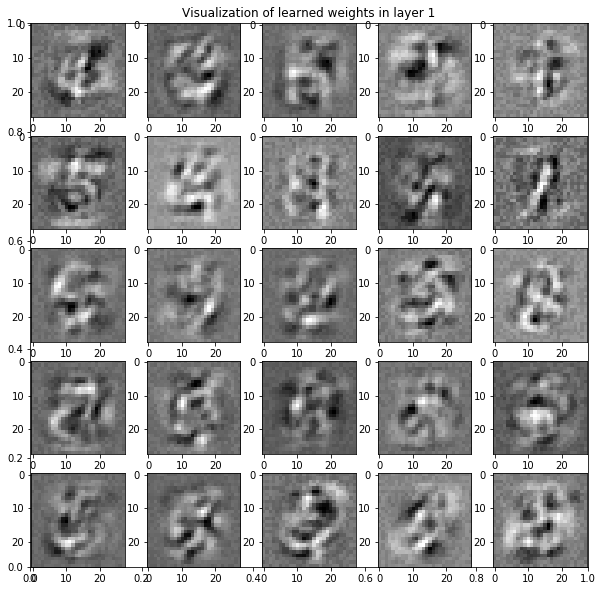

In [13]:
idx_layer = 1
learned_weights = dbn.rbm_layers[idx_layer-1].W.transpose(0,1).numpy()
fig = plt.figure(3, figsize=(10,10))
plt.title('Visualization of learned weights in layer {}'.format(idx_layer))
for i in range(25):
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)

plt.savefig('./images/dbn_trained_layer_{}.png'.format(idx_layer))
plt.show()

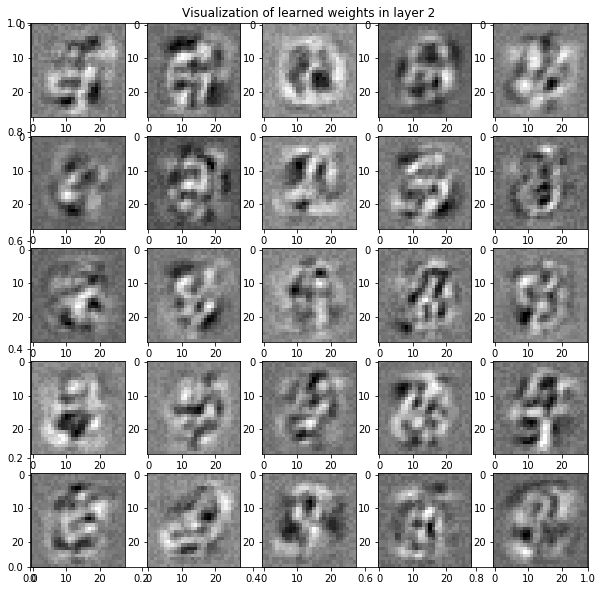

In [14]:
idx_layer = 2
learned_weights = dbn.rbm_layers[idx_layer-1].W.transpose(0,1).numpy()
fig = plt.figure(3, figsize=(10,10))
plt.title('Visualization of learned weights in layer {}'.format(idx_layer))
for i in range(25):
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)

plt.savefig('./images/dbn_trained_layer_{}.png'.format(idx_layer))
plt.show()

In [15]:
digits = 5
particular_mnist = []

limit = mnist_datasets.train_data.shape[0]
for i in range(limit):
    if(mnist_datasets.train_labels[i] == digits):
        particular_mnist.append(mnist_datasets.train_data[i].numpy())

In [16]:
print('Number of digits: {}'.format(len(particular_mnist)))

Number of digits: 5421


In [17]:
train_data = torch.stack([torch.Tensor(i) for i in particular_mnist])
train_label = torch.stack([torch.Tensor(digits) for i in range(len(particular_mnist))])

In [18]:
n_epochs = 20
dbn.train_static(train_data, train_label, 20, batch_size)

Training the RBM layer index: 1
RBM Net is fitting: 542it [00:06, 79.10it/s]
Epoch: 1, Average Cost: 0.14747825264930725, STD Cost: 0.01791125349700451, Average Gradient: 11823.6513671875, STD Gradient: 637.9600830078125
RBM Net is fitting: 542it [00:08, 67.09it/s]
Epoch: 2, Average Cost: 0.13626950979232788, STD Cost: 0.01640223152935505, Average Gradient: 11620.3896484375, STD Gradient: 608.0947265625
RBM Net is fitting: 542it [00:07, 68.31it/s]
Epoch: 3, Average Cost: 0.13265298306941986, STD Cost: 0.015957102179527283, Average Gradient: 11594.7578125, STD Gradient: 610.216552734375
RBM Net is fitting: 542it [00:07, 75.98it/s]
Epoch: 4, Average Cost: 0.1303033083677292, STD Cost: 0.015869295224547386, Average Gradient: 11579.197265625, STD Gradient: 617.0187377929688
RBM Net is fitting: 542it [00:06, 79.23it/s]
Epoch: 5, Average Cost: 0.12867771089076996, STD Cost: 0.01570933684706688, Average Gradient: 11565.3896484375, STD Gradient: 611.4921264648438
RBM Net is fitting: 542it [00:

The original number: 1


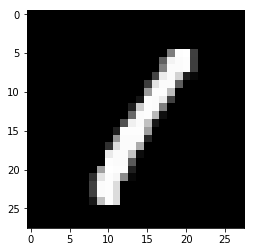

The reconstructed image


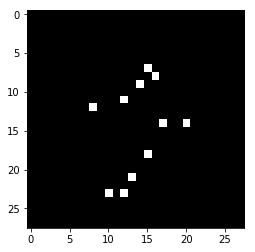

In [19]:
idx = 3
image = mnist_datasets.train_data[3]
reconstructed_image = image.view(1, -1).type(torch.FloatTensor)

_, reconstructed_image = dbn.reconstruct(reconstructed_image)
reconstructed_image = reconstructed_image.view((28,28))

print('The original number: {}'.format(mnist_datasets.train_labels[idx]))
plt.imshow(image, cmap='gray')
plt.show()

print('The reconstructed image')
plt.imshow(reconstructed_image, cmap='gray')
plt.show()

---